
<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_MFK_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox with multifidelity data to build a surrogate model 
SMT which is a python toolbox for building a surrogate model.</b></div>

Mostafa Meliani ISAE-SUPAERO student

Nathalie BARTOLI ONERA/DTIS/M2CI - May 2024
`version SMT 2.6 and above`

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. 
    The doc is available here: http://smt.readthedocs.io/en/latest/
</p>


For the multifidelity extension, a description of the algorithm is available here https://arc.aiaa.org/doi/pdf/10.2514/6.2019-3236

In [16]:
!pip install smt




# Multi-Fidelity Kriging 

We are interested in learning a high-fidelity function while using low-fidelity information sources to enhance the model, for that we use Le Gratiet recursive formulation of multi-fidelity Kriging.

<p class="alert alert-warning" style="padding:1em">
An important assumption by using this recursive formulation is the nested DOE. 
If we have thow fidelity levels (HF and LF)
$$X_{HF} \subset X_{LF}$$
 </p>   

### Kennedy O'Hagan/Le Gratiet recursive formulation:
To perform Le Gratiet's learning, we first learn the lowest fidelity, then we consecutively learn the relationship between every two consecutive fidelity levels (scaling factor $\rho_{k-1}$ and discrepancy function $\delta_k(\cdot)$).

$$\mu_{k} = \rho_{k-1}\;\mu_{k-1} + \mu_{\delta_k}\\
\sigma^2_{k} = \rho_{k-1}^2\;\sigma^2_{k-1}+\sigma^2_{\delta_k}$$

![Multi-Fidelity 1-D toy problem](co-krigeage.png)

This generally results in a better surrogate model compared to training the high-fidelity alone.

### SMT 
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt

We import the needed packages

In [17]:
from smt.applications import MFK
import numpy as np
from matplotlib import pyplot as plt
from smt.applications.mfk import NestedLHS
%matplotlib inline

## 1- Build a multifidelity model using two fidelity levels

In [18]:
#defining low and high fidelity functions
def LF_function(x):
    return 0.5*((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.5)*10. - 5

def HF_function(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

Text(0, 0.5, '$y$')

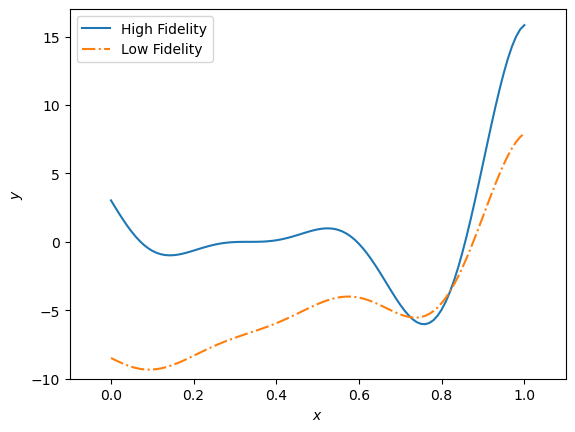

In [19]:
# Ploting High and low fidelity functions

x = np.linspace(0, 1, 101, endpoint = True).reshape(-1,1)
plt.figure()

plt.plot(x, HF_function(x), label ='High Fidelity')
plt.plot(x, LF_function(x), linestyle = '-.' , label ='Low Fidelity')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')


#### Sampling
The idea when building a mutli-fidelity design of experiment is to cover as much space as possible with low-fidelity data and use enough high fidelity samples to learn the relationship between fidelity-levels.

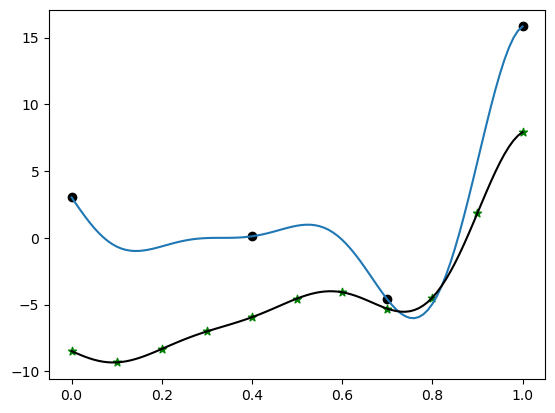

In [20]:
#Linear sampling
ndim=1
Xt_c = np.linspace(0, 1, 11, endpoint=True).reshape(-1, ndim)
#To have nested DOE
Xt_e = np.array([0.0,0.4, 0.7, 1.0]).reshape(-1, ndim)


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

plt.plot(x, HF_function(x), label ='High Fidelity')
plt.plot(x, LF_function(x) , c ='k', label ='Low Fidelity')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')


Building a SMT object has many options, you can check all the options in the doc website: http://smt.readthedocs.io

In [21]:
# build the MFK object 
sm = MFK(theta0=Xt_e.shape[1] * [1.0])

# low-fidelity dataset names being integers from 0 to level -1
sm.set_training_values(Xt_c, yt_c, name = 0) 
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e) 

# train the model
sm.train()

# test training
x = np.linspace(0, 1, 101, endpoint = True).reshape(-1,1)

# query the outputs
y = sm.predict_values(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...


D:\bartoli\Documents\Dev_Python38_39\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


   Training - done. Time (sec):  0.3228102
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009992
   
   Prediction time/pt. (sec) :  0.0000099
   


D:\bartoli\Documents\Dev_Python38_39\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


Text(0, 0.5, '$y$')

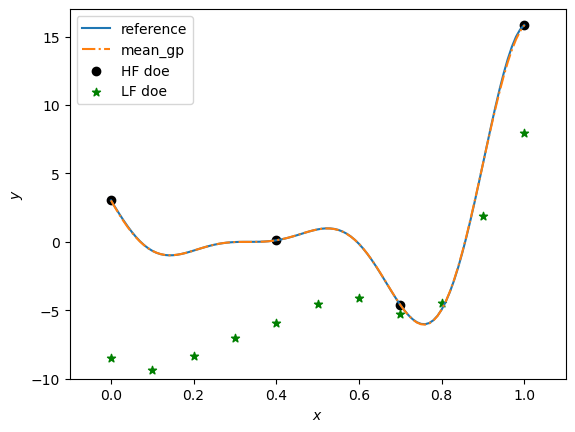

In [22]:
# plot the outputs 
plt.plot(x, HF_function(x), label ='reference')
plt.plot(x, y, linestyle = '-.' , label ='mean_gp')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [23]:
# Accessing the variance and derivative of the model
MSE = sm.predict_variances(x)
der = sm.predict_derivatives(x, kx=0)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0014491
   
   Prediction time/pt. (sec) :  0.0000143
   


Text(0, 0.5, '$y$')

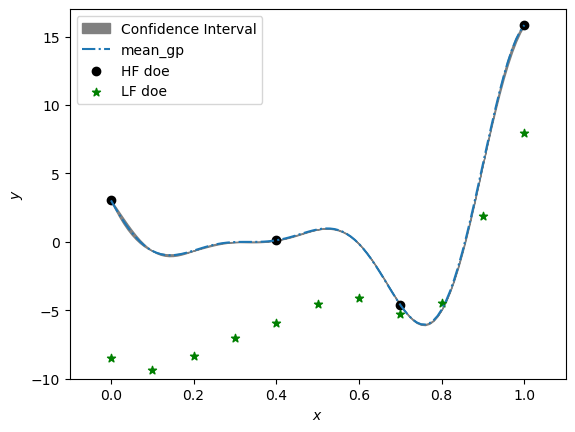

In [24]:
# plot the variance 
plt.fill_between(np.ravel(x), np.ravel(y-2*np.sqrt(MSE)), np.ravel(y+2*np.sqrt(MSE)),color='grey' ,label ='Confidence Interval')
plt.plot(x, y, linestyle = '-.' , label ='mean_gp')
plt.scatter(Xt_e, yt_e, marker = 'o' , color ='k', label ='HF doe')
plt.scatter(Xt_c, yt_c, marker = '*' , color ='g', label ='LF doe')

plt.legend(loc=0)
plt.ylim(-10,17)
plt.xlim(-0.1,1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

<div class="alert alert-danger" >
<p> In most of the surrogate models $y\in\mathbb{R}$, so if you have multiple outputs $y\in\mathbb{R}^d$ (which are considered as independant outputs), add an external loop to build one surrogate model per output. The correlations betweens outputs are not taken into account. 
</div>

## 2- Build a multifidelity model using  three fidelity levels


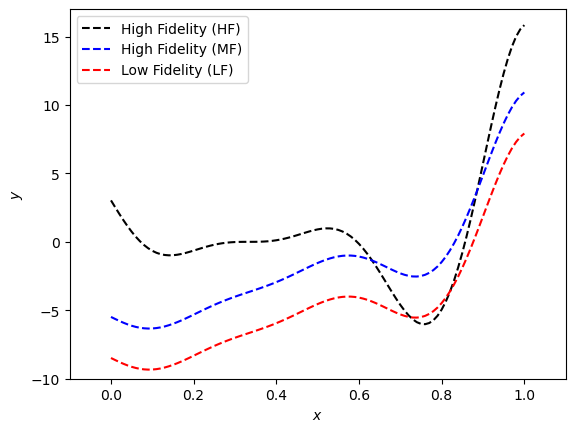

In [25]:
def LF_function(x):
    return 0.5*((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.5)*10. - 5

def MF_function(x):
    return LF_function(x) + 3

def HF_function(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

plt.figure()
plt.plot(x, HF_function(x), '--k', label='High Fidelity (HF)')
plt.plot(x, MF_function(x), '--b', label='High Fidelity (MF)')
plt.plot(x, LF_function(x), '--r', label='Low Fidelity (LF)')
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

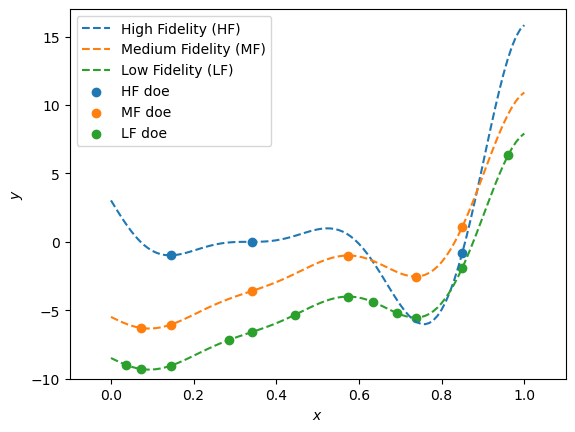

In [26]:
# LHS sampling with nested DOE: 3 levels, 1 dimension, 3 HF points
ndim = 1
nlvl = 3
ndoe_hf = 3

#Nested DOE
xlimits = np.array([[0.0, 1.0]])
xdoes = NestedLHS(nlevel=nlvl, xlimits=xlimits, random_state=2)
Xt_c, Xt_m, Xt_e = xdoes(ndoe_hf)


#Expensive DOE with 3 points = Xt_e
#Intermediate DOE with 6 points = Xt_m
#Cheap DOE with 16 points Xt_c


# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_m = MF_function(Xt_m)
yt_c = LF_function(Xt_c)


plt.figure()
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, MF_function(x), '--C1', label='Medium Fidelity (MF)')
plt.plot(x, LF_function(x), '--C2', label='Low Fidelity (LF)')
plt.scatter(Xt_e, yt_e, marker='o', color='C0', label='HF doe')
plt.scatter(Xt_m, yt_m, marker='o', color='C1', label='MF doe')
plt.scatter(Xt_c, yt_c, marker='o', color='C2', label='LF doe')
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [32]:
# Build the MFK object with 3 levels
sm = MFK(theta0=[1e-2], theta_bounds=[1e-06, 100.0], hyper_opt='TNC') 
# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_m, yt_m, name=1)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)
# train the model
sm.train()


# test 
nlvl = len(sm.X)
# query the outputs
y = sm.predict_values(x)
y0 = sm._predict_intermediate_values(x, 1)
y1 = sm._predict_intermediate_values(x, 2)
var = sm.predict_variances(x)
varAll, _ =  sm.predict_variances_all_levels(x)
var0 = varAll[:,0].reshape(-1,1)
var1 = varAll[:,1].reshape(-1,1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...


D:\bartoli\Documents\Dev_Python38_39\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(
D:\bartoli\Documents\Dev_Python38_39\smt\smt\surrogate_models\krg_based.py:968: UserWarning: R is too ill conditioned. Poor combination of regression model and observations.
  warnings.warn(


   Training - done. Time (sec):  0.6925194
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0019999
   
   Prediction time/pt. (sec) :  0.0000198
   


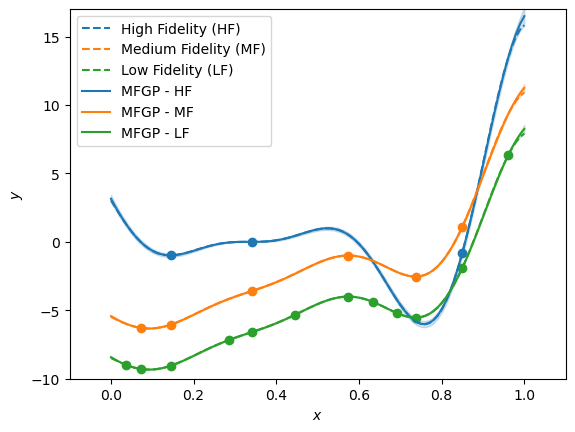

In [33]:
plt.figure()

plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, MF_function(x), '--C1', label='Medium Fidelity (MF)')
plt.plot(x, LF_function(x), '--C2', label='Low Fidelity (LF)')
plt.plot(x, y, 'C0', label='MFGP - HF')
plt.fill_between(np.ravel(x), np.ravel(y-3*np.sqrt(var)),
                 np.ravel(y+3*np.sqrt(var)),
                 color='C0',alpha=0.2)# ,label ='Confidence Interval 99% HF')
plt.plot(x, y1, 'C1', label='MFGP - MF')
plt.fill_between(np.ravel(x), np.ravel(y1-3*np.sqrt(var1)),
                  np.ravel(y1+3*np.sqrt(var1)),
                  color='C1',alpha=0.2)#,label ='Confidence Interval 99% MF')
plt.plot(x, y0, 'C2', label='MFGP - LF')
plt.fill_between(np.ravel(x), np.ravel(y0-3*np.sqrt(var0)),
                  np.ravel(y0+3*np.sqrt(var0)),
                  color='C2',alpha=0.2)#,label ='Confidence Interval 99% LF')
plt.scatter(Xt_e, yt_e, marker='o', color='C0')#, label='HF doe')
plt.scatter(Xt_m, yt_m, marker='o', color='C1')#, label='MF doe')
plt.scatter(Xt_c, yt_c, marker='o', color='C2')#, label='LF doe')
plt.legend(loc=0)
plt.ylim(-10, 17)
plt.xlim(-0.1, 1.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [34]:

#to get some hyperparameter values
print('optimal theta:', sm.optimal_theta)

optimal theta: [array([1.2237604]), array([1.e-06]), array([1.e-06])]


In [37]:
#to compute the variance of HF model at training points 
# query the outputs
y_train = sm.predict_values(Xt_e)
#y0_train = sm2._predict_intermediate_values(x, 1)
var_train = sm.predict_variances(Xt_e)
#relatve error at training points
t_error = np.linalg.norm(y_train - yt_e) / np.linalg.norm(yt_e)
        #self.assert_error(t_error, 0.0, 1e-2)
print('Relative prediction error on training points', t_error)
print('Variance at training points', np.linalg.norm(var_train))


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 3
   
   Predicting ...
   Predicting - done. Time (sec):  0.0018716
   
   Prediction time/pt. (sec) :  0.0006239
   
Relative prediction error on training points 4.246179322960907e-07
Variance at training points 0.007604679823067443
